In [2]:
from copy import deepcopy
from tqdm import tqdm
import random
from collections import defaultdict
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment

In [40]:
# TD class with states represented with integers
class TemporalDifference:
    def __init__(self, oiv = 0, alpha=0.1, epsilon=0.1, lambd=0.9, gamma=0.9):
        """
        Args:
        - lanes (int): Number of lanes (default is 5).
        - initial_distance (int): The distance from destination.
        - alpha (float): learning rate, between 0 and 1
        - epsilon (float): exploration rate between, 0 and 1
        - lambd (float): contribution of past rewards, between 0 and 1
        - gamma (float): discount factor, between 0 and 1
        - oiv (int/float): optimistic initial value
        """
        super().__init__()
        self.Env = environment.TrafficEnvironment()
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambd = lambd
        self.gamma = gamma
        self.oiv = oiv

        # Action space: 3 actions (0: move left, 1: stay, 2: move right)
        self.action_space = 3

        # use nested dictionaries for Q, E.
        # {state: [s_a1, s_a2, s_a3]}
        self.Q = defaultdict(lambda: np.zeros(self.action_space) + self.oiv)
        self.E = defaultdict(lambda: np.zeros(self.action_space) + self.oiv)

        # store 'best model'
        self.best_Q = None
        self.best_reward = float('-inf')

    def get_best_action(self, state: tuple):
        # if state not present, act random
        if state not in self.Q.keys():
            return random.randint(0,self.action_space-1)

        # get the dictionary of actions and their values for this state
        action_values = self.Q[state]
        # find the action with the maximum value
        best_action = np.argmax(action_values)
        return best_action

    # define epsilon greedypolicy
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0,self.action_space-1)
        else:
            return self.get_best_action(state)
    
    def transform_state(self, state, num_discrete_levels=5):
            """
            Normalize the distance to a percentage of the initial distance and discretize clearance rates.
            
            Args:
            - state: The original state tuple from the environment.
            - initial_distance: Initial distance to the destination for normalizing distance.
            - num_discrete_levels: Number of discrete levels for clearance rates.

            Returns:
            - transformed_state: Tuple containing the normalized distance percentage and discrete clearance rates.
            """
            # Normalize distance as a percentage of initial distance
            distance_percentage = int((state[14] / self.Env.initial_distance) * 10)
            
            # Get current lane and clearance rates for adjacent lanes
            current_lane = int(state[15])
            clearance_rates = state[16:]
            
            # Discretize clearance rates to specified levels (e.g., 1 to 10)
            min_rate, max_rate = 5, max(20, max(clearance_rates))
            left_lane_rate = (clearance_rates[current_lane - 1] if current_lane > 1 else None)
            right_lane_rate = (clearance_rates[current_lane] if current_lane < len(clearance_rates) else None)
            current_lane_rate = clearance_rates[current_lane - 1]
            
            # Discretize clearance rates within the specified range
            def discretize_rate(rate):
                if rate is None:
                    return 0  # Assign 0 if no lane exists (e.g., left lane when in the leftmost position)
                return int((rate - min_rate) / (max_rate - min_rate) * (num_discrete_levels - 1)) + 1

            left_lane_rate = discretize_rate(left_lane_rate)
            right_lane_rate = discretize_rate(right_lane_rate)
            current_lane_rate = discretize_rate(current_lane_rate)

            # Return transformed state with normalized distance and discrete clearance rates
            return (distance_percentage, current_lane, current_lane_rate, left_lane_rate, right_lane_rate)

    def train(self, num_episodes = 1000 , on_policy = True, save_model = False):

        #initialize list to store episode history
        self.total_reward_list = []
        self.total_steps_list = []
        truncated_count = 0

        for episode in tqdm(range(num_episodes)):
            episode_memory = []  # to be used when lambd = 1
            
            #reset episode, re-initialize E and total_reward
            state = self.Env.reset()
            flattened_state = tuple(item for tup in state for item in tup)
            state = self.transform_state(flattened_state)

            terminated = False
            truncated = False
            self.E.clear()
            steps = 0
            total_reward = 0

            #get first action
            action = self.epsilon_greedy_policy(state)

            # if log:
            #     self.Env.render()
            #     self.Env.logger.info(f"Action: {action}")

            while not terminated and not truncated:
                #perform action
                next_state, reward, terminated = self.Env.step(action)
                flattened_next_state = tuple(item for tup in next_state for item in tup)

                next_state = self.transform_state(flattened_next_state)

                #accumulate steps and reward
                steps += 1
                total_reward += reward

                #get next state and action
                next_action = self.epsilon_greedy_policy(next_state)
                
                #update tables(dictionaries)
                if self.lambd == 1:
                    episode_memory.append([state, action, reward])
                    state, action = next_state, next_action
                    state = tuple(state)
                    continue

                if on_policy:   # SARSA
                    delta = reward + self.gamma * (not terminated) * self.Q[next_state][next_action] - self.Q[state][action]
                else:           # Q-learning
                    best_next_action = self.get_best_action(next_state)
                    delta = reward + self.gamma * (not terminated) * self.Q[next_state][best_next_action] - self.Q[state][action]
                
                # if TD(0), no need to perform epsilon decay
                if self.lambd == 0:
                    # update Q values
                    self.Q[state][action] += self.alpha * delta
                
                # if TD(lambd), update E & Q
                else:
                    self.E[state][action] += 1
                    for state in self.Q.keys():
                        for action in range(self.action_space):
                            self.Q[state][action] += self.alpha * delta * self.E[state][action]
                            self.E[state][action] *= self.gamma * self.lambd
                if truncated:
                    truncated_count += 1

                if terminated:
                    break

                # move to next state and action pair
                state, action = next_state, next_action
                                
                # if log:
                #     self.Env.render()
                #     self.Env.logger.info(f"Action: {action}")
            
            # Append total rewards and steps after the episode ends
            self.total_reward_list.append(reward)
            self.total_steps_list.append(steps)
            
            if save_model == True:
                # Calculate average reward over last 100 episodes (or all if less than 100)
                window_size = min(100, len(self.total_reward_list))
                avg_reward = sum(self.total_reward_list[-window_size:]) / window_size
                
                # Save if best performance
                if avg_reward > self.best_reward:
                    self.best_reward = avg_reward
                    self.best_Q = dict(self.Q)  # Create a deep copy of current Q-values
                
            if self.lambd == 1:
                G = 0
                for state, action, reward in reversed(episode_memory):
                    G = reward + self.gamma * G
                    self.Q[state][action] += self.alpha * (G - self.Q[state][action])

        if episode % 1000 == 0:
            print(f'Sum of rewards at episode {episode} is {reward}' )

        return self.total_reward_list, self.total_steps_list

##### Visualise training

In [41]:
def plot_training_metrics(rewards, steps, window_size=50):
    """
    Plot training metrics (rewards and steps) with rolling mean (window_size)
    
    Args:
    rewards: list of episode rewards
    steps: list of episode steps
    window_size: size of rolling window for smoothing
    """
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create dataframes for easier plotting
    df_rewards = pd.DataFrame({
        'Episode': range(len(rewards)),
        'Reward': rewards,
        'Rolling Mean': pd.Series(rewards).rolling(window=window_size).mean()
    })
    
    df_steps = pd.DataFrame({
        'Episode': range(len(steps)),
        'Steps': steps,
        'Rolling Mean': pd.Series(steps).rolling(window=window_size).mean()
    })
    
    # Plot rewards
    sns.scatterplot(data=df_rewards, x='Episode', y='Reward', 
                   alpha=0.3, color='blue', ax=ax1, label='Reward')
    sns.lineplot(data=df_rewards, x='Episode', y='Rolling Mean',
                color='red', ax=ax1, linewidth=2, label=f'Rolling Mean (window={window_size})')
    ax1.set_title('Rewards per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    
    # Plot steps
    sns.scatterplot(data=df_steps, x='Episode', y='Steps',
                   alpha=0.3, color='blue', ax=ax2, label='Steps')
    sns.lineplot(data=df_steps, x='Episode', y='Rolling Mean',
                color='red', ax=ax2, linewidth=2, label=f'Rolling Mean (window={window_size})')
    ax2.set_title('Steps per Episode')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Number of Steps')
    
    # Adjust layout and display
    plt.tight_layout()
    return fig

In [62]:
def train_model(num_iterations = 3, num_episodes = 1000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9):
    iteration_rew = []
    iteration_avg_rew = []
    iteration_avg_steps = []
    for i in range(num_iterations):
        sarsa = TemporalDifference(oiv = 0, alpha=alpha, epsilon=epsilon, lambd=lambd, gamma=gamma)
        total_reward_list, total_steps_list = sarsa.train(num_episodes = num_episodes, on_policy = on_policy, save_model = False)
        total_rew = sum(total_reward_list)
        avg_rew = np.mean(total_reward_list)
        avg_steps = np.mean(total_steps_list)

        iteration_rew.append(total_rew)
        iteration_avg_rew.append(avg_rew)
        iteration_avg_steps.append(avg_steps)

        print(f'At iteration {i+1}')
        print(f'State-size = {len(sarsa.Q)}')
        print(f'Sum of total rewards = {total_rew}')
        print(f'Average total reward per episode = {avg_rew}')
        print(f'Average steps per episode = {avg_steps}')

        # plot training metrics
        plot_training_metrics(total_reward_list, total_steps_list, window_size=50)
        plt.show()
        
    print("\nAverage result per iteration")
    print(f'Sum of total rewards = {np.mean(iteration_rew)}')
    print(f'Average total reward per episode = {np.mean(iteration_avg_rew)}')
    print(f'Average steps per episode = {np.mean(iteration_avg_steps)}')

#### SARSA

100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s]


At iteration 1
State-size = 346
Sum of total rewards = 468.8999999999991
Average total reward per episode = 0.4689
Average steps per episode = 1021.339


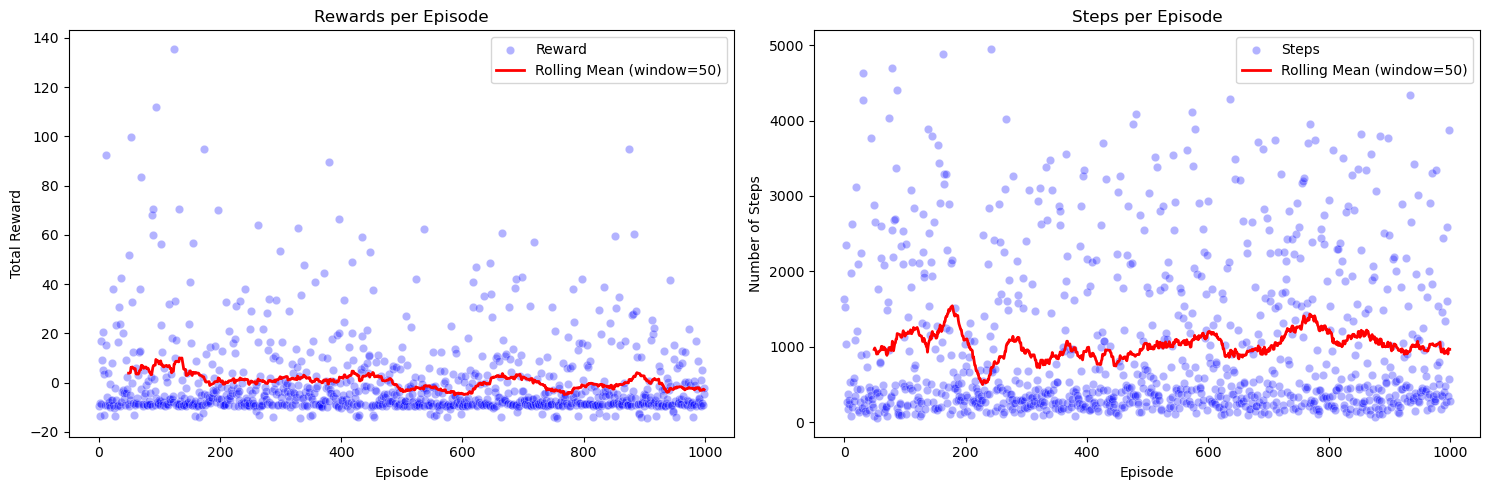

100%|██████████| 1000/1000 [00:42<00:00, 23.60it/s]


At iteration 2
State-size = 411
Sum of total rewards = 661.7000000000005
Average total reward per episode = 0.6617000000000002
Average steps per episode = 1070.573


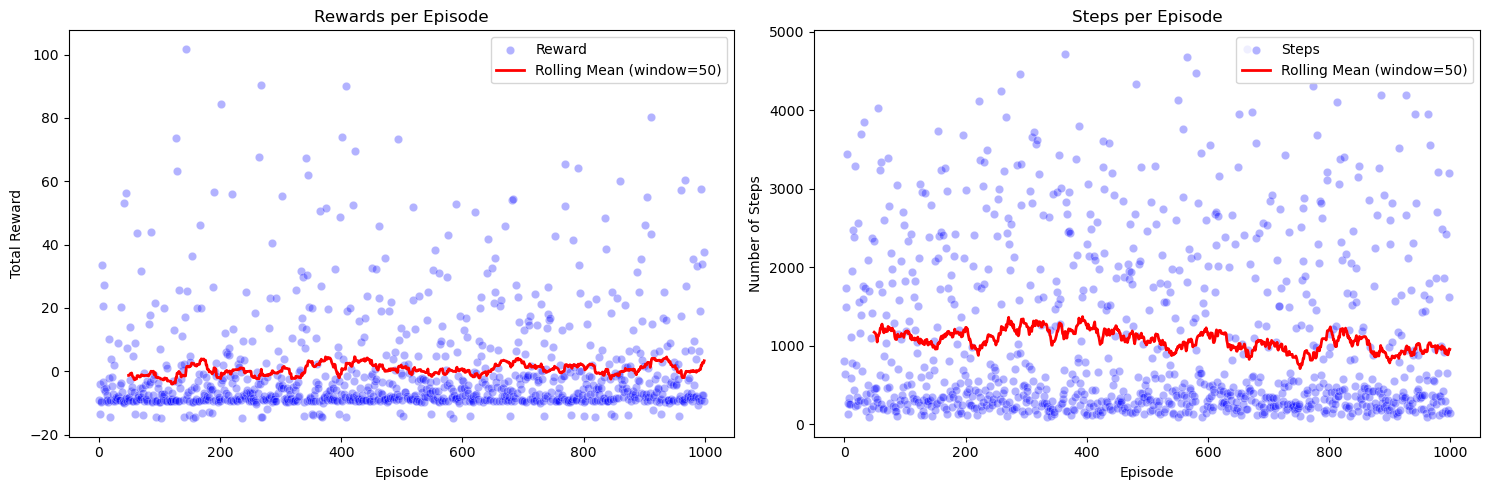

100%|██████████| 1000/1000 [00:39<00:00, 25.31it/s]


At iteration 3
State-size = 372
Sum of total rewards = 1417.9999999999998
Average total reward per episode = 1.418
Average steps per episode = 1008.081


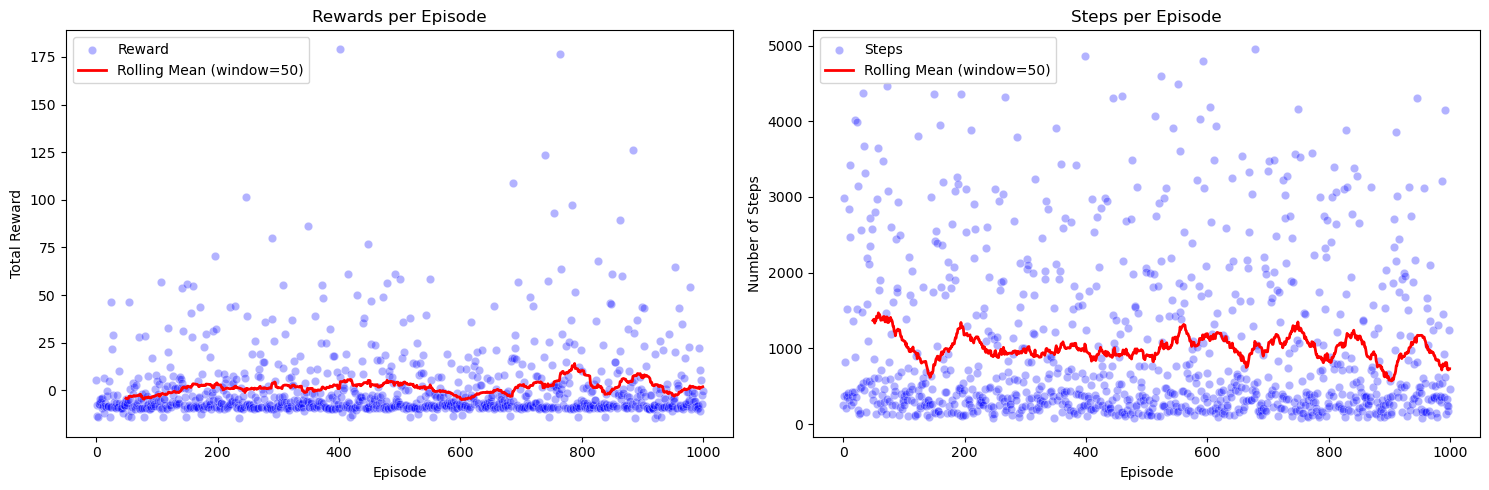


Average result per iteration
Sum of total rewards = 849.5333333333332
Average total reward per episode = 0.8495333333333335
Average steps per episode = 1033.3310000000001


In [63]:
train_model(num_iterations = 3, num_episodes = 1000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9) # SARSA

In [ ]:
train_model(num_iterations = 3, num_episodes = 5000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9) # SARSA

In [ ]:
# SARSA
train_model(num_iterations = 3, num_episodes = 10000, on_policy = True, alpha=0.1, epsilon=0.1, lambd=0, gamma=0.9) 

#### Search alpha & gamma

In [ ]:
# SARSA
alpha = [0.1, 0.05, 0.1]
gamma = [0.9, 0.95, 0.99]
for alpha in alpha:
    for gamma in gamma:
        print(f'\n\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 3, num_episodes = 100, on_policy = True, alpha=alpha, epsilon=0.1, lambd=0, gamma=gamma) 

#### Q learning

In [ ]:
# Q-learning
alpha = [0.1, 0.05, 0.1]
gamma = [0.9, 0.95, 0.99]
for alpha in alpha:
    for gamma in gamma:
        print(f'\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 1, num_episodes = 10000, on_policy = False, alpha=alpha, epsilon=0.1, lambd=0, gamma=gamma) 

#### Monte Carlo

In [ ]:
# MC with SARSA

alpha = [0.1, 0.05, 0.1]
gamma = [0.9, 0.95, 0.99]
for alpha in alpha:
    for gamma in gamma:
        print(f'\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 1, num_episodes = 10000, on_policy = On, alpha=alpha, epsilon=0.1, lambd=0, gamma=gamma) 

In [ ]:
# MC with Q-learning

alpha = [0.1, 0.05, 0.1]
gamma = [0.9, 0.95, 0.99]
for alpha in alpha:
    for gamma in gamma:
        print(f'\n--------------------Hyperparameters alpha = {alpha}, gamma = {gamma}--------------------')
        train_model(num_iterations = 1, num_episodes = 10000, on_policy = False, alpha=alpha, epsilon=0.1, lambd=0, gamma=gamma) 